### About
### Estimate AOD(Aerosol Optical Depth) using Sentinel-2 data, leveraging its spectral bands and spatial resolution to improve accuracy.

### This notebook is about estimating Aerosol Optical Depth using each spectral band individually.

### The AOD estimation process,
- Select band pixel
- create embedding
- train the xgboost model using the embedding vectors

### Import necessary packages and libraries

In [1]:
!pip install imagecodecs -qq

In [2]:
import pandas as pd #dataframe manipulation
import numpy as np  #for numerical process
import seaborn as sns #for visualization
from matplotlib import pyplot as plt #for visualization
from PIL import Image, ImageDraw, ImageEnhance,ImageStat #for read the image
import skimage.color 
import skimage.io as skio
from skimage.transform import resize
import skimage.util
from skimage.measure import shannon_entropy, blur_effect
import imagehash #for calculation hash value of image
import cv2 #for read the image
import re
import os
import itertools
import os
#import distance
import time
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook,tqdm
from IPython.display import display, HTML
import tifffile
import shutil
from tqdm import tqdm
import json
import random

from sklearn.model_selection import train_test_split,KFold
import logging
from IPython.display import clear_output
from shapely.geometry import Polygon


import xgboost as xgb
import torch
import timm
from torchvision import transforms
import tifffile

### Import data

In [3]:
train = pd.read_csv("/kaggle/input/solafune-aerosol-optical-depth-estimation/train_answer.csv")

train = train.rename(columns = {'train_1.tif':'filename'})
train = train.rename(columns = {'0.04161685225788304':'label'})
test = pd.DataFrame({'filename':[f"test_{i}.tif" for i in range(1,1490)]})


train_path = "/kaggle/input/solafune-aerosol-optical-depth-estimation/train_images/train_images/"
test_path = "/kaggle/input/solafune-aerosol-optical-depth-estimation/test_images/test_images/"

In [4]:
{'B1_Aerosols':0,'B2_Blue':1,'B3_Green':2,'B4_Red':3,
'B5_Red_Edge_1':4,'B6_Red_Edge_2':5,'B7_Red_Edge_3':6,
'B8_NIR':7,'B8A_Red_Edge_4':8,'B9_Water_vapor':9,'SWIR_Cirrus':10,'B11_SWIR_1':11,
'B12_SWIR_2':12}

{'B1_Aerosols': 0,
 'B2_Blue': 1,
 'B3_Green': 2,
 'B4_Red': 3,
 'B5_Red_Edge_1': 4,
 'B6_Red_Edge_2': 5,
 'B7_Red_Edge_3': 6,
 'B8_NIR': 7,
 'B8A_Red_Edge_4': 8,
 'B9_Water_vapor': 9,
 'SWIR_Cirrus': 10,
 'B11_SWIR_1': 11,
 'B12_SWIR_2': 12}

### Split data

In [5]:
X_train, X_test = train_test_split(train, test_size=0.2,random_state=42)                                                                

### Embedding model

In [6]:
model_name = 'efficientnet_b0.ra_in1k'
model = timm.create_model(model_name, pretrained=True, num_classes=0,in_chans=1)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Convert image to tensor

In [7]:
# Define the transform pipeline: resize, normalize, and convert to tensor
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])


### Function to get embedding

In [8]:
def get_image_embedding(df,path,band):
    embed=[]
    for img in tqdm(df['filename']):
        #im=rasterio.open(f"{path}{img}").read().astype(np.float64)
        
        image = open_image(f"{path}{img}",band)
        
        # Apply the transformations
        image = transform(image)
        
        # Add a batch dimension (N, C, H, W) for the model input
        image = image.unsqueeze(0)
        
         # Ensure the model is in evaluation mode
        model.eval()

        # Disable gradient calculation for inference
        with torch.no_grad():
            embedding = model(image)
        embed.append(embedding.detach().cpu().numpy())
        del image,embedding
    return embed

### Evaluation metric

In [9]:
from scipy.stats import pearsonr

def pearsonr_eval(preds, dtrain):
    labels = dtrain.get_label()
    return 'pearsonr', pearsonr(preds, labels)[0]


### Function to read image

In [10]:
def open_image(path,band):
    img=tifffile.imread(path)
   # new_image=np.stack((img[:,:,7],
      #                 img[:,:,10],img[:,:,3]),axis=-1)
    new_image=img[:,:,band]
                        
    new_image = Image.fromarray((new_image*255).astype(np.uint8))
    
    #new_image = new_image.resize((512,512))
    
    return new_image
   

### AOD model

In [11]:
class AodModel():
    def __init__(self,train_df, val_df, train_label, val_label, test_df, train_path, test_path):
        self.train_df = train_df
        self.val_df = val_df
        self.train_label = train_label
        self.val_label = val_label
        self.test_df =  test_df
        self.train_path = train_path
        self.test_path = test_path
        self.score = dict()
        self.val_pred_results = dict()
        self.test_pred_results = dict()
        self.final_sub = dict()
    def train_model(self):
        for i in range(13):
            print(f"Prepaing training data for band:{i+1}\n")
            train_embeddings=get_image_embedding(self.train_df ,self.train_path ,i)
            print(f"training data preparation for band:{i+1} is done\n")
        
            print(f"Preparing validation data for band:{i+1}\n")
            validation_embeddings=get_image_embedding(self.val_df ,self.train_path ,i)
            print(f"Validation data preparation for band:{i+1} is done\n")
            
            print(f"Training model for band {i+1}\n")
            #xgboost model
            reg=xgb.XGBRegressor(random_state=42)
            reg.fit(np.concatenate(train_embeddings), self.train_label,
                eval_set=[(np.concatenate(validation_embeddings),self.val_label)],
                eval_metric=pearsonr_eval,
                early_stopping_rounds=200, verbose=False)
            val_pred = reg.predict(np.concatenate(validation_embeddings))
            score_result = pearsonr(self.val_label,val_pred,)[0].round(2)*100 
            print(f"Band {i+1} Validation  pearsonr:{score_result}\n")
            self.val_pred_results[f"band_{i+1}"] = val_pred
            self.score[f"band_{i+1}"] = score_result
            print(f"Testing data preparation for band:{i+1}\n")
            test_embedding = get_image_embedding(self.test_df, self.test_path ,i)
            print(f"Testing data preparation for band:{i+1} is done\n")
            print(f"Predict test data for band_{i+1}\n")
            test_pred = reg.predict(np.concatenate(test_embedding))
            self.test_pred_results[f"band_{i+1}"] = test_pred
            print(f"Test Prediction is done for band_{i+1}\n")
            print("="*100)
        self.create_test_result_df()

    def create_test_result_df(self):
        for key, value in self.test_pred_results.items():
            self.final_sub[key] = pd.DataFrame({'fielname':self.test_df['filename'],'AOD':value})

        os.makedirs("/kaggle/working/Channel_wise_prediction", exist_ok = True)
        os.chdir("/kaggle/working/Channel_wise_prediction/")
        ref_name = "efficientnet_b0.ra_in1k_embeddings_xgb_baseline"
        
        for key, value in self.final_sub.items():
            value.to_csv(f"{ref_name}_{key}.csv",index=False)

        pd.DataFrame(list(self.score.items()),columns=['Band', 'Validation_score']).to_csv(f"{ref_name}_validation_results.csv",index=False)
        os.chdir("/kaggle/working/")
        shutil.make_archive(f"{ref_name}_band_1-13", 'zip', "/kaggle/working/Channel_wise_prediction/")
        print("Final submission files created")
        
    
        
       
        

In [12]:
aod = AodModel(train_df = X_train
               ,val_df = X_test
               ,train_label = X_train['label']
               ,val_label = X_test['label']
               ,test_df = test
               ,train_path = train_path
               ,test_path = test_path)

### Train the model

In [13]:
aod.train_model()

Prepaing training data for band:1



100%|██████████| 3571/3571 [09:28<00:00,  6.28it/s]


training data preparation for band:1 is done

Preparing validation data for band:1



100%|██████████| 893/893 [02:32<00:00,  5.87it/s]


Validation data preparation for band:1 is done

Training model for band 1

Band 1 Validation  pearsonr:69.0

Testing data preparation for band:1



100%|██████████| 1489/1489 [03:22<00:00,  7.37it/s]


Testing data preparation for band:1 is done

Predict test data for band_1

Test Prediction is done for band_1

Prepaing training data for band:2



100%|██████████| 3571/3571 [08:22<00:00,  7.11it/s]


training data preparation for band:2 is done

Preparing validation data for band:2



100%|██████████| 893/893 [02:07<00:00,  7.03it/s]


Validation data preparation for band:2 is done

Training model for band 2

Band 2 Validation  pearsonr:71.0

Testing data preparation for band:2



100%|██████████| 1489/1489 [03:28<00:00,  7.15it/s]


Testing data preparation for band:2 is done

Predict test data for band_2

Test Prediction is done for band_2

Prepaing training data for band:3



100%|██████████| 3571/3571 [08:24<00:00,  7.07it/s]


training data preparation for band:3 is done

Preparing validation data for band:3



100%|██████████| 893/893 [02:05<00:00,  7.11it/s]


Validation data preparation for band:3 is done

Training model for band 3

Band 3 Validation  pearsonr:66.0

Testing data preparation for band:3



100%|██████████| 1489/1489 [03:30<00:00,  7.06it/s]


Testing data preparation for band:3 is done

Predict test data for band_3

Test Prediction is done for band_3

Prepaing training data for band:4



100%|██████████| 3571/3571 [08:24<00:00,  7.07it/s]


training data preparation for band:4 is done

Preparing validation data for band:4



100%|██████████| 893/893 [02:08<00:00,  6.93it/s]


Validation data preparation for band:4 is done

Training model for band 4

Band 4 Validation  pearsonr:63.0

Testing data preparation for band:4



100%|██████████| 1489/1489 [03:35<00:00,  6.92it/s]


Testing data preparation for band:4 is done

Predict test data for band_4

Test Prediction is done for band_4

Prepaing training data for band:5



100%|██████████| 3571/3571 [08:51<00:00,  6.71it/s]


training data preparation for band:5 is done

Preparing validation data for band:5



100%|██████████| 893/893 [02:11<00:00,  6.79it/s]


Validation data preparation for band:5 is done

Training model for band 5

Band 5 Validation  pearsonr:67.0

Testing data preparation for band:5



100%|██████████| 1489/1489 [03:39<00:00,  6.77it/s]


Testing data preparation for band:5 is done

Predict test data for band_5

Test Prediction is done for band_5

Prepaing training data for band:6



100%|██████████| 3571/3571 [08:40<00:00,  6.86it/s]


training data preparation for band:6 is done

Preparing validation data for band:6



100%|██████████| 893/893 [02:02<00:00,  7.27it/s]


Validation data preparation for band:6 is done

Training model for band 6

Band 6 Validation  pearsonr:75.0

Testing data preparation for band:6



100%|██████████| 1489/1489 [03:26<00:00,  7.23it/s]


Testing data preparation for band:6 is done

Predict test data for band_6

Test Prediction is done for band_6

Prepaing training data for band:7



100%|██████████| 3571/3571 [08:02<00:00,  7.40it/s]


training data preparation for band:7 is done

Preparing validation data for band:7



100%|██████████| 893/893 [01:59<00:00,  7.44it/s]


Validation data preparation for band:7 is done

Training model for band 7

Band 7 Validation  pearsonr:77.0

Testing data preparation for band:7



100%|██████████| 1489/1489 [03:15<00:00,  7.62it/s]


Testing data preparation for band:7 is done

Predict test data for band_7

Test Prediction is done for band_7

Prepaing training data for band:8



100%|██████████| 3571/3571 [07:50<00:00,  7.59it/s]


training data preparation for band:8 is done

Preparing validation data for band:8



100%|██████████| 893/893 [01:57<00:00,  7.57it/s]


Validation data preparation for band:8 is done

Training model for band 8

Band 8 Validation  pearsonr:73.0

Testing data preparation for band:8



100%|██████████| 1489/1489 [03:23<00:00,  7.33it/s]


Testing data preparation for band:8 is done

Predict test data for band_8

Test Prediction is done for band_8

Prepaing training data for band:9



100%|██████████| 3571/3571 [08:07<00:00,  7.33it/s]


training data preparation for band:9 is done

Preparing validation data for band:9



100%|██████████| 893/893 [02:00<00:00,  7.39it/s]


Validation data preparation for band:9 is done

Training model for band 9

Band 9 Validation  pearsonr:69.0

Testing data preparation for band:9



100%|██████████| 1489/1489 [03:28<00:00,  7.15it/s]


Testing data preparation for band:9 is done

Predict test data for band_9

Test Prediction is done for band_9

Prepaing training data for band:10



100%|██████████| 3571/3571 [08:08<00:00,  7.31it/s]


training data preparation for band:10 is done

Preparing validation data for band:10



100%|██████████| 893/893 [01:59<00:00,  7.48it/s]


Validation data preparation for band:10 is done

Training model for band 10

Band 10 Validation  pearsonr:52.0

Testing data preparation for band:10



100%|██████████| 1489/1489 [03:22<00:00,  7.36it/s]


Testing data preparation for band:10 is done

Predict test data for band_10

Test Prediction is done for band_10

Prepaing training data for band:11



100%|██████████| 3571/3571 [07:52<00:00,  7.56it/s]


training data preparation for band:11 is done

Preparing validation data for band:11



100%|██████████| 893/893 [01:58<00:00,  7.53it/s]


Validation data preparation for band:11 is done

Training model for band 11

Band 11 Validation  pearsonr:7.000000000000001

Testing data preparation for band:11



100%|██████████| 1489/1489 [03:18<00:00,  7.49it/s]


Testing data preparation for band:11 is done

Predict test data for band_11

Test Prediction is done for band_11

Prepaing training data for band:12



100%|██████████| 3571/3571 [08:03<00:00,  7.39it/s]


training data preparation for band:12 is done

Preparing validation data for band:12



100%|██████████| 893/893 [02:00<00:00,  7.39it/s]


Validation data preparation for band:12 is done

Training model for band 12

Band 12 Validation  pearsonr:56.00000000000001

Testing data preparation for band:12



100%|██████████| 1489/1489 [03:20<00:00,  7.41it/s]


Testing data preparation for band:12 is done

Predict test data for band_12

Test Prediction is done for band_12

Prepaing training data for band:13



100%|██████████| 3571/3571 [08:05<00:00,  7.36it/s]


training data preparation for band:13 is done

Preparing validation data for band:13



100%|██████████| 893/893 [02:00<00:00,  7.43it/s]


Validation data preparation for band:13 is done

Training model for band 13

Band 13 Validation  pearsonr:49.0

Testing data preparation for band:13



100%|██████████| 1489/1489 [03:25<00:00,  7.26it/s]


Testing data preparation for band:13 is done

Predict test data for band_13

Test Prediction is done for band_13

Final submission files created


### Band wise validation score

In [14]:
 pd.DataFrame(list(aod.score.items()),columns=['Band', 'Validation_score']).sort_values("Validation_score",ascending=False)

,Band,Validation_score
6,band_7,77.0
5,band_6,75.0
7,band_8,73.0
1,band_2,71.0
0,band_1,69.0
8,band_9,69.0
4,band_5,67.0
2,band_3,66.0
3,band_4,63.0
11,band_12,56.0


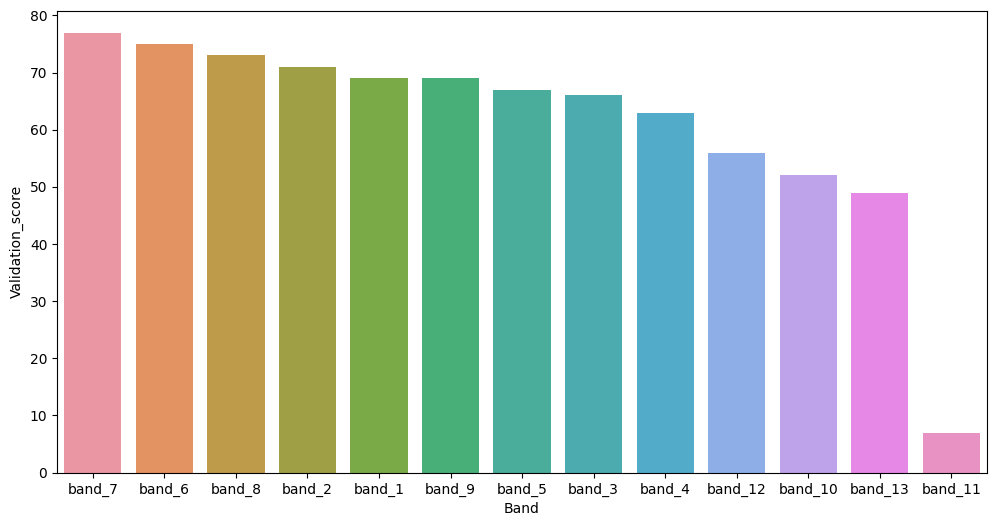

In [15]:
_=plt.figure(figsize=(12,6))
sns.barplot(data = pd.DataFrame(list(aod.score.items()),columns=['Band', 'Validation_score']).sort_values("Validation_score",ascending=False),
            x='Band', y='Validation_score');

### Actual vs  Prediction

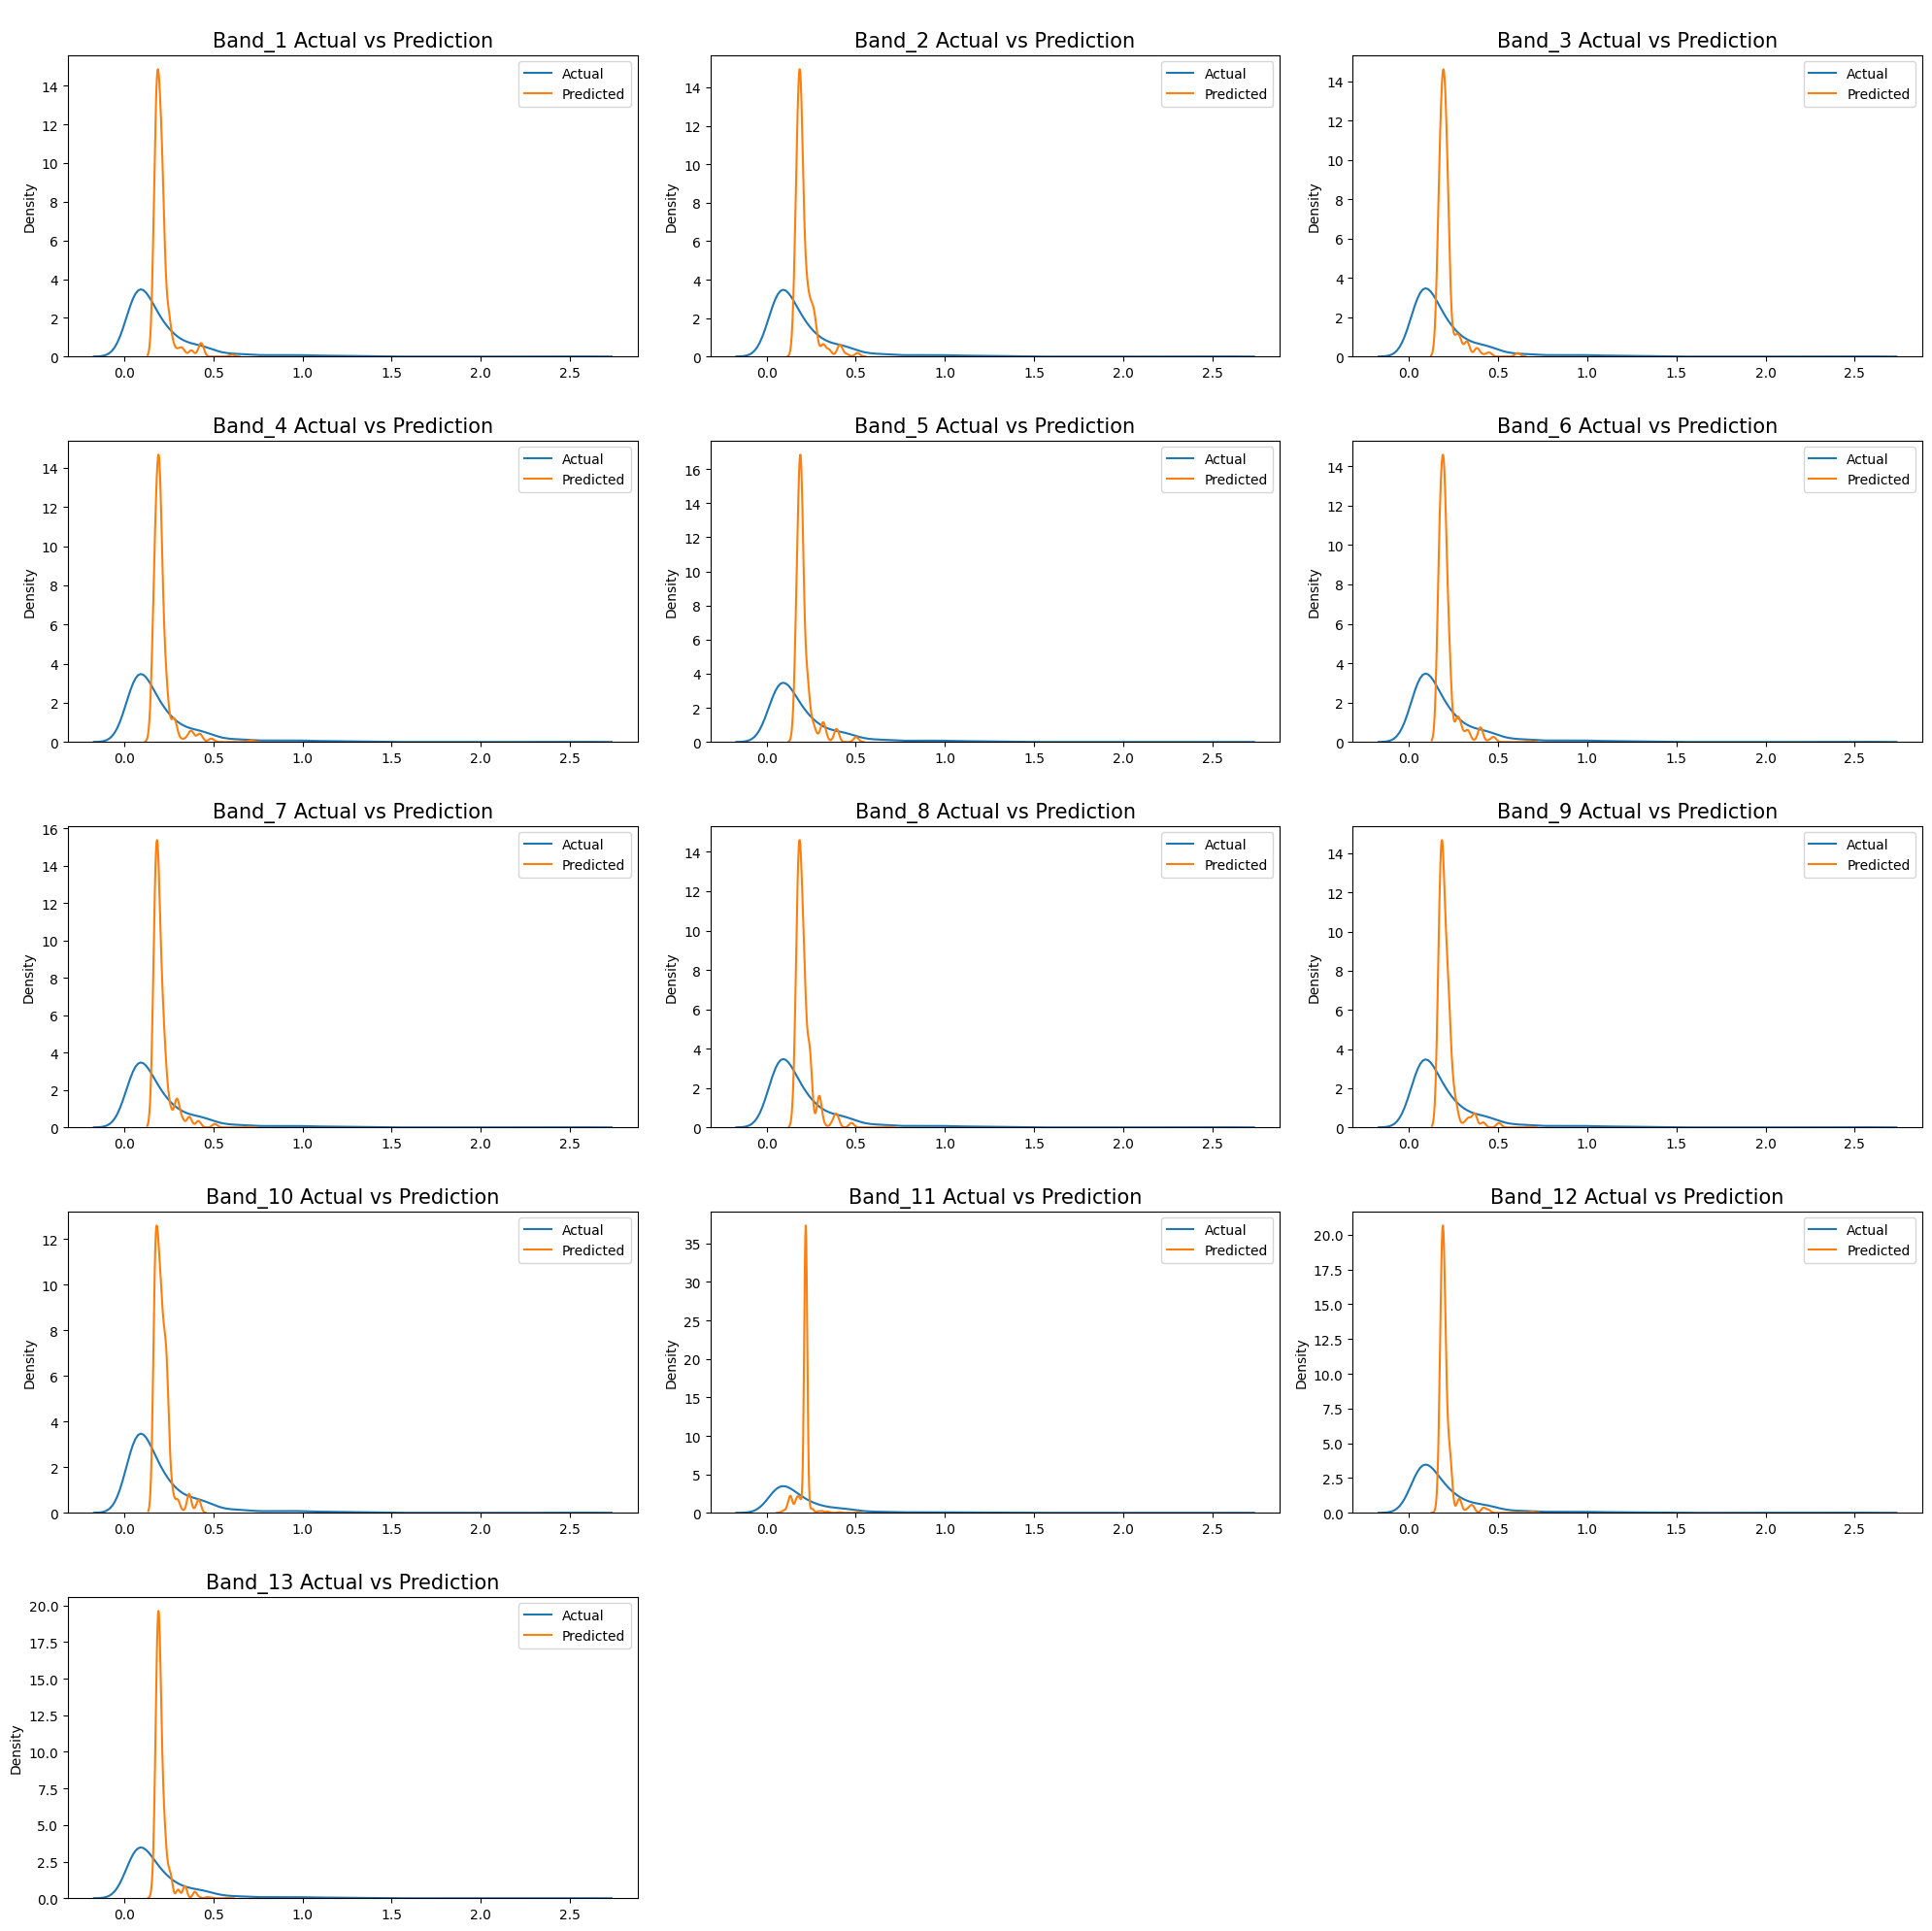

In [16]:
fig=plt.subplots(figsize=(20, 20))
for i,band  in enumerate(aod.val_pred_results.keys()):    
    _=plt.subplot(5,3,i+1,)
    _=sns.kdeplot(X_test['label'], label = 'Actual')
    _=sns.kdeplot(aod.val_pred_results[band],label='Predicted')
    _=plt.legend()
    _=plt.title(f"\n{band.capitalize()} Actual vs Prediction",fontsize=15)
    _=plt.xlabel("")
   # _=plt.xticks(fontsize=15)
    _=plt.tight_layout()
plt.show()